CREATE GRID OVER PARIS

In [1]:
# NECESSARY FOR FUNCTIONS
import osmnx as ox
import numpy as np
import geopandas as gpd
from shapely.geometry import box

In [2]:
# INTERNAL TESTING
from shapely.plotting import plot_polygon
import matplotlib.pyplot as plt
from src.ingest import make_grid

1. Start very simply, create a box
2. Create lots of boxes, forming one giant box and store them. Ok, this creates a grid.
3. Get paris outline from osmnx. 
4. Create grid but this time inside paris outline
5. plot paris outline and the grid for verification

In [3]:
# Create a dictionary to store the city grids
city_grids = {}

# Store grids for each city in the dictionary
city_grids["Paris"] = make_grid.main("Paris, France", 1000)
city_grids["Madrid"] = make_grid.main("Madrid, Spain", 1000)
city_grids["Roma"] = make_grid.main("Roma, Italy", 1000)
city_grids["Berlin"] = make_grid.main("Berlin, Germany", 1000)

AttributeError: 'str' object has no attribute 'exterior'

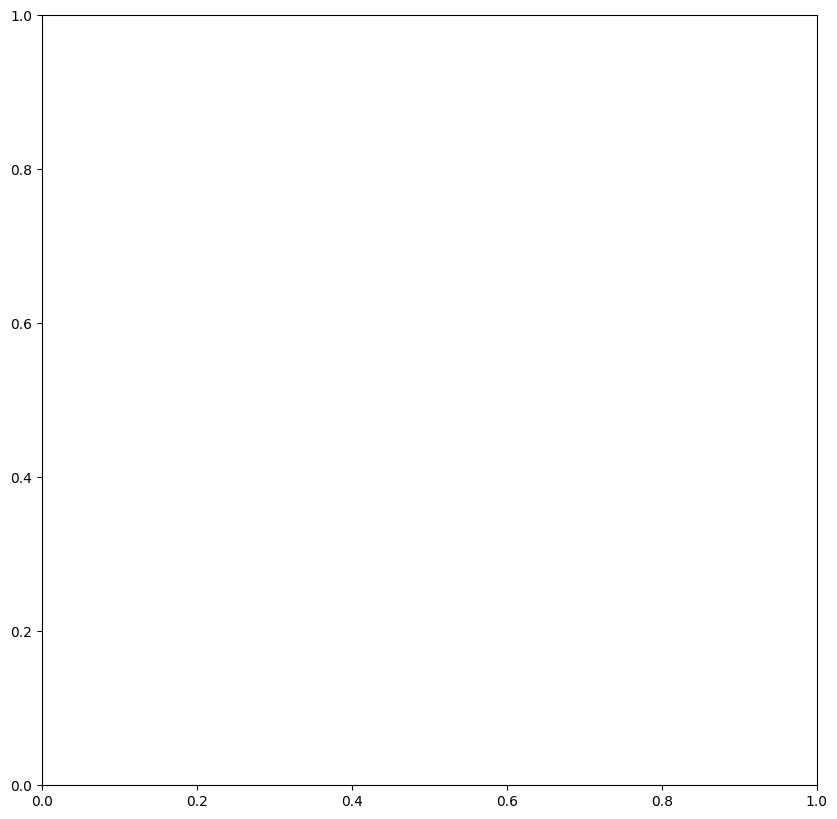

In [ ]:
# DOES NOT WORK ANYMORE

fig, ax = plt.subplots(figsize=(10, 10))
for city, grid in city_grids.items():
    for square in grid:
        x, y = square.exterior.xy
        ax.fill(x, y, edgecolor='black', facecolor='none', linewidth=1)

ax.set_aspect('equal')  # Keep aspect ratio square
ax.set_title('European Capitals')
plt.show()